In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from tqdm.notebook import tqdm
import mne

In [2]:
path = "/media/dan/Data/data/baseline_patients/baseline_edfs/001_Baseline.EDF"
raw = mne.io.read_raw_edf(path)


Extracting EDF parameters from /media/dan/Data/data/baseline_patients/baseline_edfs/001_Baseline.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
with h5py.File("/media/dan/Data/outputs/ubiquitous-spork/pyspi_combined_patient_hdf5s/001_20250414.h5", 'r') as f:
    data = f['metadata/adjacency_matrices']['pdist_cosine'][()]
    soz = f['metadata/patient_info/soz'][()]
    ilae = f['metadata/patient_info/ilae'][()]
    names = f['metadata/patient_info/electrode_data/electrode'][()]
    # byte to string
    names = [name.decode('utf-8') for name in names]
raw_data = raw.get_data(picks=[f"EEG {x}" for x in names]) * 1e6


In [35]:
d = np.expand_dims(raw_data, axis=0) - np.expand_dims(raw_data, axis=1)
# d = np.diff(d, axis=2)
d.shape

(118, 118, 312064)

In [9]:
# remove numbers from names

n = [re.sub(r'\d+', '', name) for name in names]

curr = 'empty'
name_mask = np.zeros(len(n))
for i, name in enumerate(n):
    if name == curr:
        name_mask[i] = 0
    else:
        curr = name
        name_mask[i] = 1

name_mask = name_mask.astype(float)


In [11]:
def make_matrix(arr, soz, name_mask, size_marking_rows=3,min_v=None,max_v=None):
    row_mask = np.repeat(soz.reshape(-1, 1), size_marking_rows, axis=1)
    name = np.repeat(name_mask.reshape(-1, 1), size_marking_rows, axis=1)
    row_mask = row_mask.astype(float)
    name = name.astype(float)
    if max_v is None:
        max_v = np.nanmax(arr)
    if min_v is None:
        min_v = np.nanmin(arr)

    a = arr.shape[0]
    masks = [row_mask.copy(), name.copy()]

    for i in range(len(masks)):
        masks[i][masks[i] == 1] = max_v
        masks[i][masks[i] == 0] = min_v

    n_marking_rows = len(masks) # soz and electrodes
    nmr = n_marking_rows*size_marking_rows

    # tmp = np.full((2*nmr+a, 2*nmr+a), np.nan) # 2 is for each side of matrix
    tmp = np.full((2*nmr+a, 2*nmr+a), min_v) # 2 is for each side of matrix
    tmp = tmp.astype(float)

    tmp[nmr:nmr+a, nmr:nmr+a] = arr

    for i in range(len(masks)):
        b = i*size_marking_rows
        e = tmp.shape[0] - b
        tmp[nmr:nmr+a, b:b+size_marking_rows] = masks[i] # left side
        # right side
        tmp[nmr:nmr+a, e-size_marking_rows:e] = masks[i]
        # top side
        tmp[b:b+size_marking_rows, nmr:nmr+a] = masks[i].T
        # bottom side
        tmp[e-size_marking_rows:e, nmr:nmr+a] = masks[i].T

    m = np.max([np.abs(max_v), np.abs(min_v)])
    return tmp, m

In [12]:
t = 500

max_v = np.nanmax(d[...,:t])
min_v = np.nanmin(d[...,:t])

for i in range(t):
    tmp, m = make_matrix(d[...,i], soz, name_mask, min_v=min_v, max_v=max_v)
    plt.imshow(tmp, cmap="seismic",interpolation="none",vmin=-m,vmax=m)
    plt.colorbar()
    plt.savefig(f'tmp/{i:07}.png')
    plt.close()

In [22]:
df = pd.DataFrame(n)
df.groupby(0).value_counts()


0
B      10
C      10
E       8
G      10
I      10
M       6
O      12
P      12
Q      12
R       6
RPI     6
S       8
W       8
Name: count, dtype: int64

In [41]:
raw_data[:2,0:2048//4].shape

(2, 512)

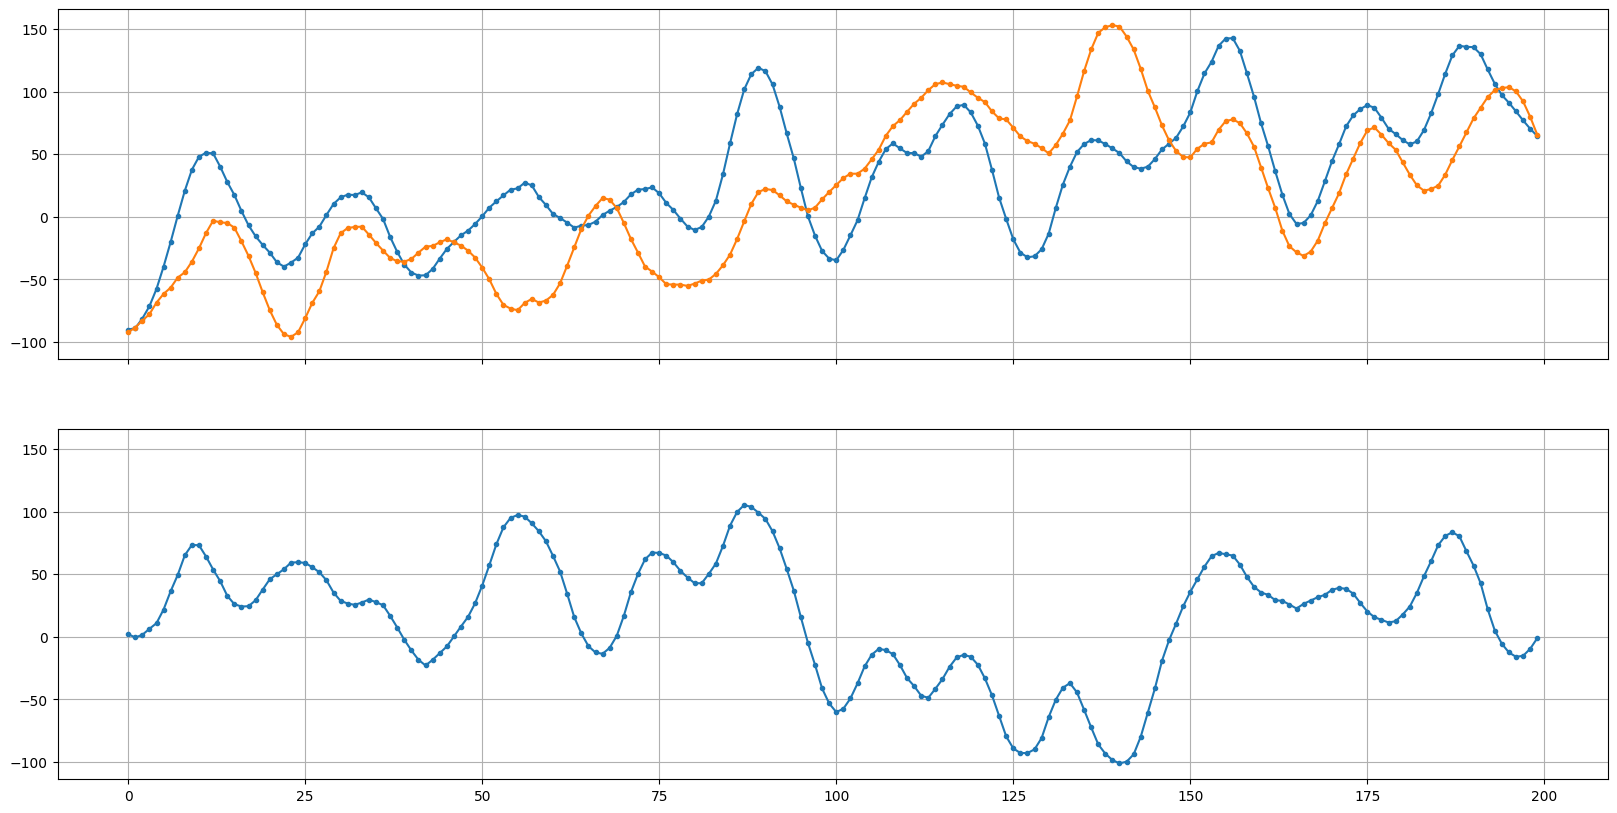

In [54]:
fig, ax = plt.subplots(2,1,figsize=(20,10), sharex=True, sharey=True)
end = 200
ax[0].plot(raw_data[:2,0:end].T, '.-');
ax[1].plot(raw_data[0,0:end] - raw_data[1,0:end], '.-');
ax[0].grid()
ax[1].grid()

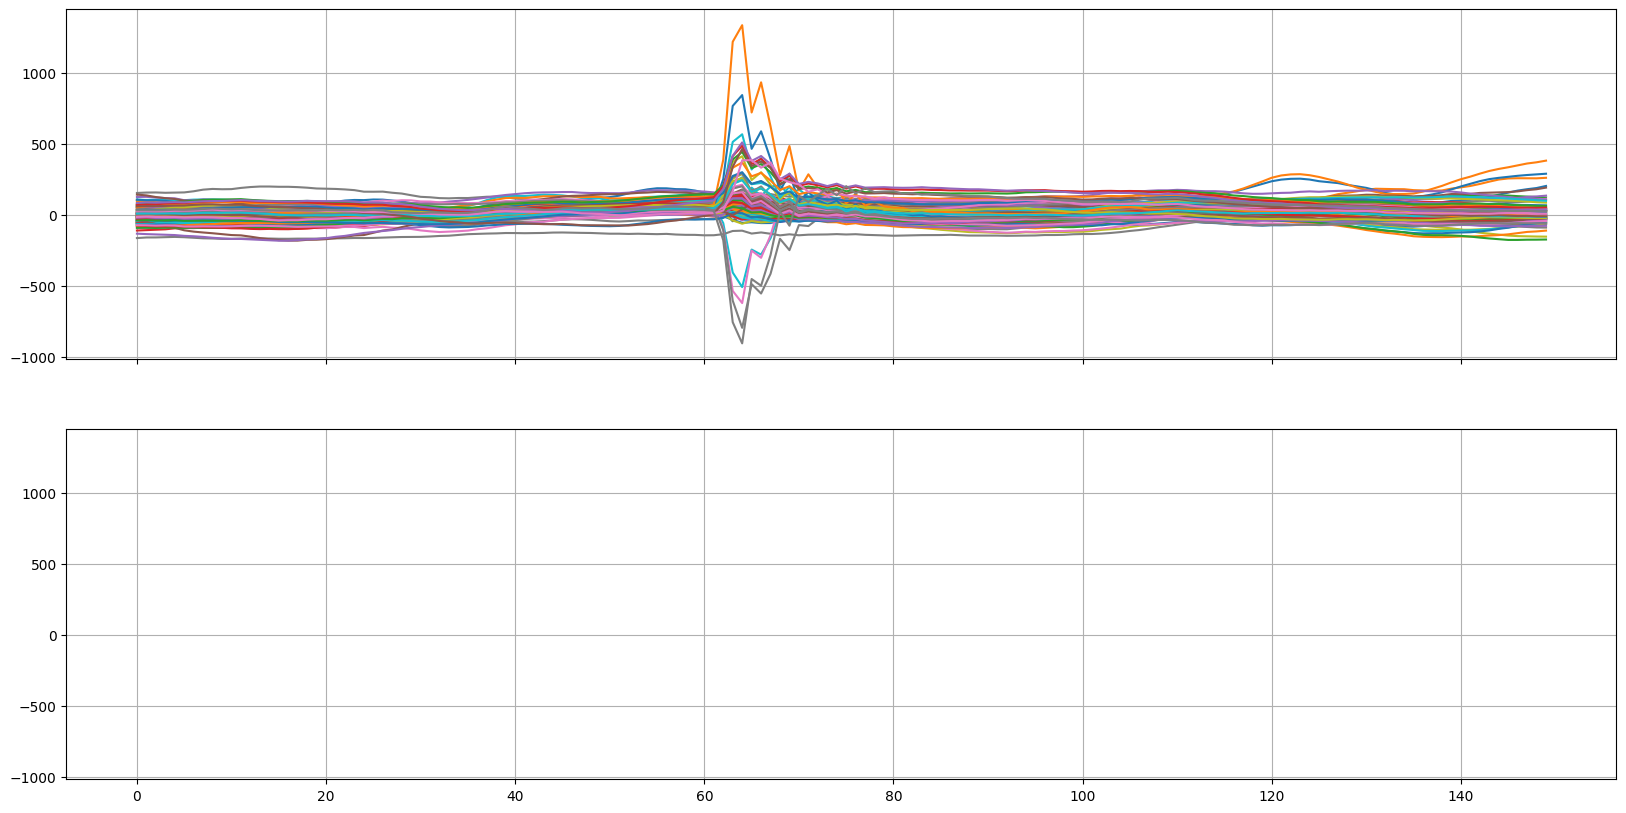

In [28]:
fig, ax = plt.subplots(2,1,figsize=(20,10), sharex=True, sharey=True)
end = 800
ax[0].plot(raw_data[:,650:end].T, '-');
# ax[1].plot(raw_data[0,0:end] - raw_data[1,0:end], '.-');
ax[0].grid()
ax[1].grid()

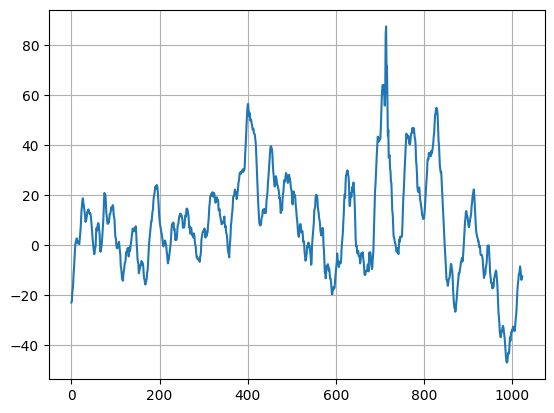

In [15]:
avg = np.mean(raw_data[:,0:2048//2],axis=0)
plt.plot(avg);
plt.grid();

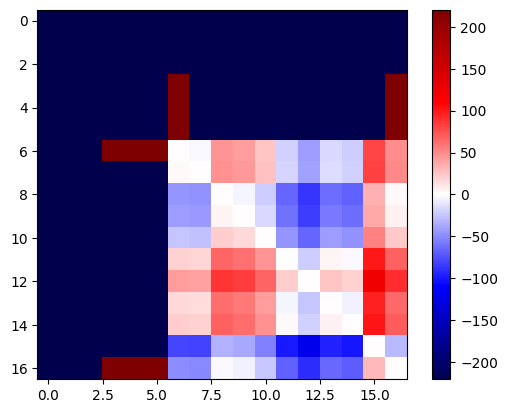

In [59]:
i = 11
plt.imshow(tmp[:nmr+i,:nmr+i], cmap="seismic",interpolation="none",vmin=-m,vmax=m)
plt.colorbar()


In [62]:
raw_data[:i,0]

array([ -89.98774701,  -92.11448844,  -43.99696345,  -48.25044633,
        -64.73269245, -109.66010529, -131.72504768, -106.20415045,
       -111.52100404,  -10.76662852,  -41.60437934])

In [65]:
raw_data[0,0] - raw_data[1,0]

2.126741435873953

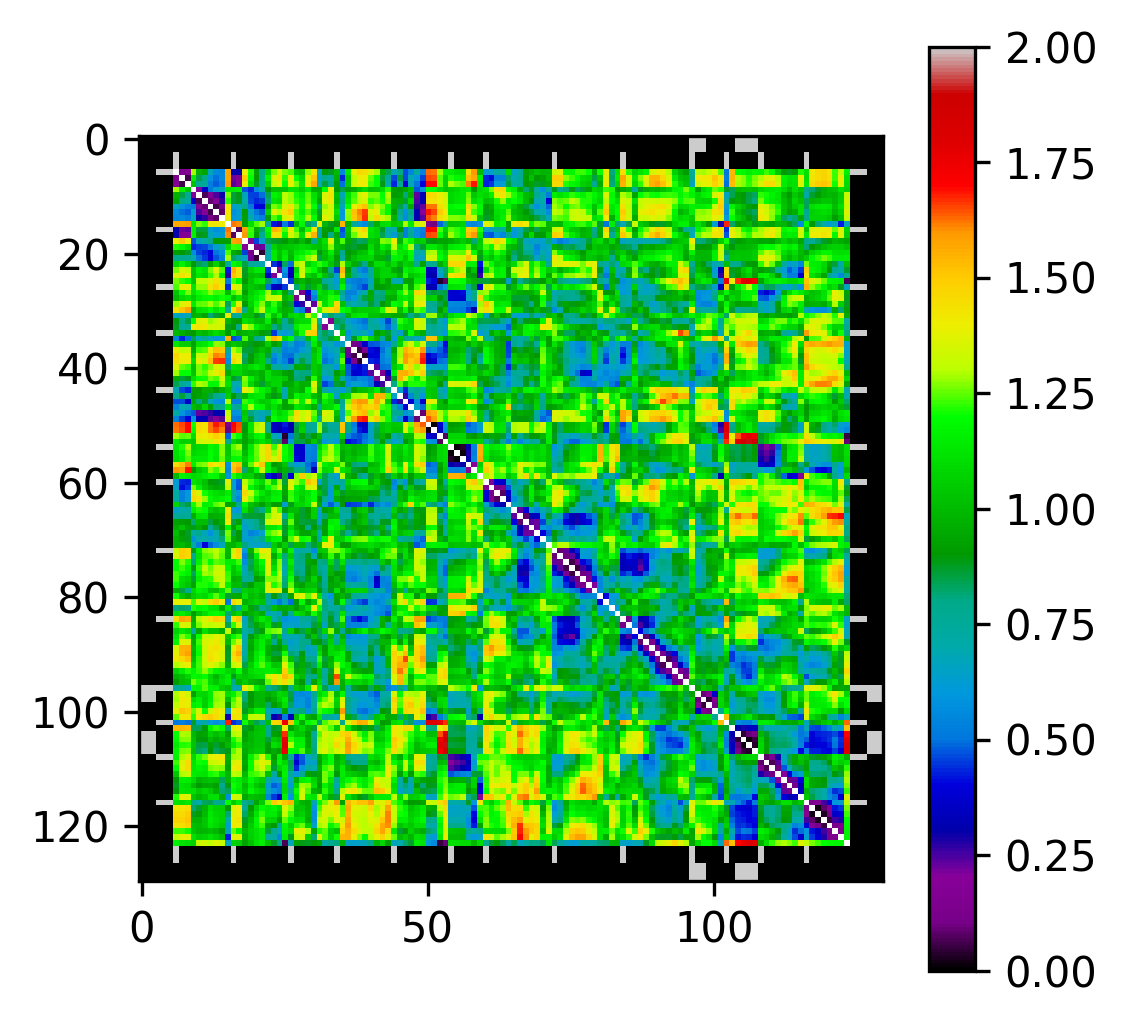

In [8]:
tmp, m = make_matrix(data[...,1], soz, name_mask, min_v=0, max_v=2)
plt.figure(dpi=300, figsize=(4,4))
plt.imshow(tmp, cmap="nipy_spectral", vmin=0, vmax=2)
plt.colorbar()

  0%|          | 0/118 [00:00<?, ?it/s]

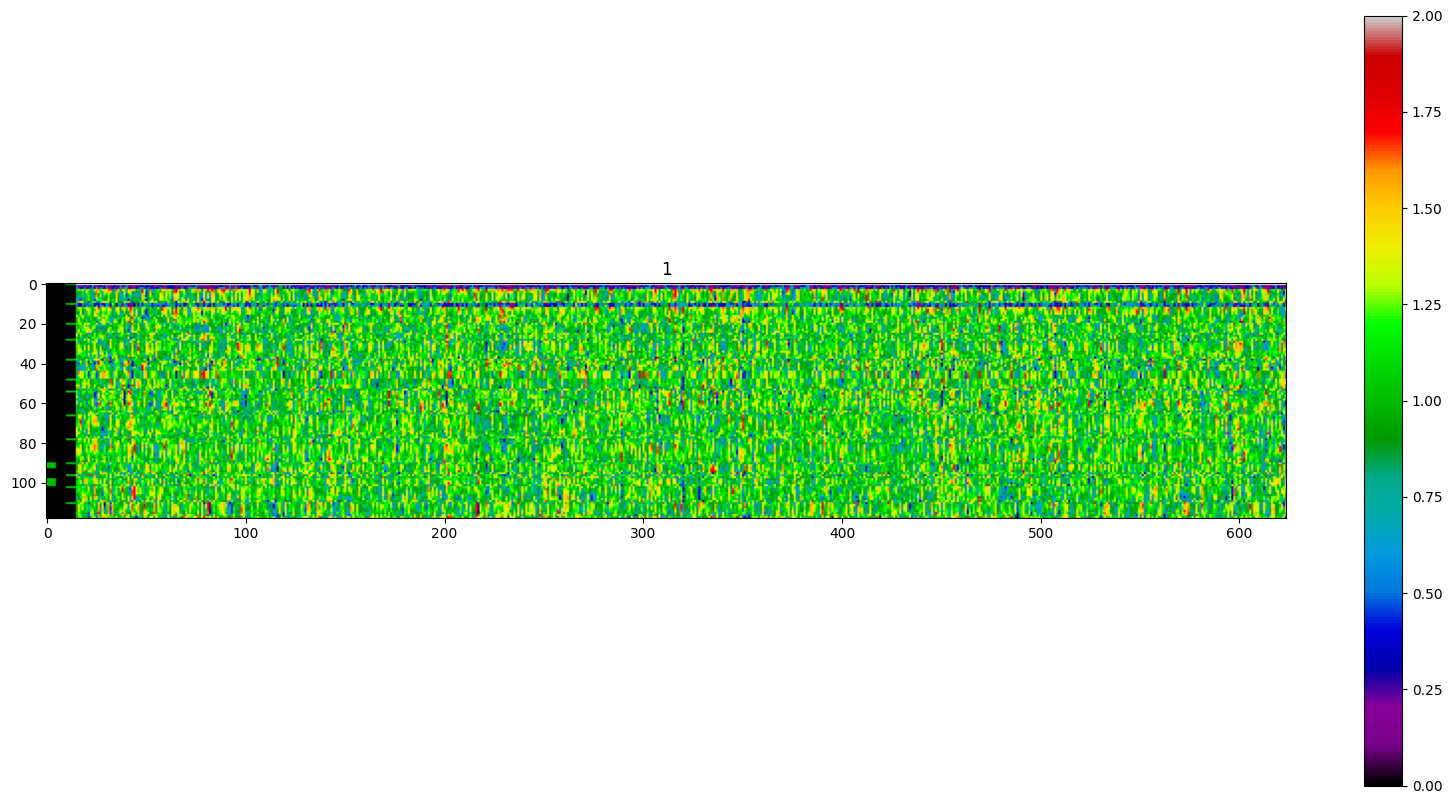

In [13]:

# diff = np.diff(data,axis=2)
diff = data.copy()

max_v = np.nanmax(diff)
min_v = np.nanmin(diff)

# normalize 0-2
# diff = (diff - min_v) / (max_v - min_v)


row_flattened = diff.reshape(-1, diff.shape[-1])


n = data.shape[0]

col_mask = np.repeat(soz, n).reshape(-1, 1)
row_mask = np.tile(soz, n).reshape(-1, 1)
name = np.tile(name_mask, n).reshape(-1, 1)


q = 5
row = np.tile(row_mask, q)
col = np.tile(col_mask, q)
name = np.tile(name, q)

mask = np.concatenate([row, col], axis=1)

# Convert mask to float type to handle the max_v and min_v values
mask = mask.astype(float)

# # fill mask with max where 1 and min where 0
# mask[mask == 1] = 1
# mask[mask == 0] = 0

mask = np.concatenate([mask, name], axis=1)

out = np.concatenate([mask, row_flattened], axis=1)

# drange = np.nanmax(np.abs(max_v), np.abs(min_v))

z = 1
for i in tqdm(np.arange(0,col.shape[0],n)):
    plt.figure(figsize=(20,10))
    plt.imshow(out[i:(i+n), :], cmap='nipy_spectral', vmin=0, vmax=2)
    plt.title(f'{z}')
    plt.colorbar()
    # plt.savefig(f'test_{z:03}.png')
    # plt.close()
    z += 1
    break
    
    

In [11]:
min_v

0.0020570366109526894

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(out[i:(i+n), :], cmap='gray', vmin=0, vmax=1)

In [93]:
# 
diff = d.copy()
diff = np.diff(diff,axis=2)

In [94]:
diff.shape

(118, 118, 312063)

In [95]:
soz_idx = np.where(soz)[0]
soz_idx

array([ 90,  91,  92,  98,  99, 100, 101])

In [108]:
i

0

In [121]:
s = diff[:,:,1024*2:1024*8]
s = s.reshape(-1,s.shape[-1])
plt.figure(figsize=(25,5))
m = 40
plt.imshow(s, cmap='gray_r', vmin=-m, vmax=m, interpolation='none')
# plt.colorbar(orientation='horizontal', aspect=50)

plt.tight_layout()
plt.savefig(f'test.png',bbox_inches='tight',dpi=300)
plt.close()

In [117]:
for i in range(diff.shape[0]):
    s = diff[i,:,1024*2:1024*8]
    plt.figure(figsize=(25,5))
    m = 40
    plt.imshow(s, cmap='gray_r', vmin=-m, vmax=m, interpolation='none')
    # plt.colorbar(orientation='horizontal', aspect=50)
    c = 'red' if i in soz_idx else 'black'
    plt.title(f'difference | {i}', color=c)
    plt.tight_layout()
    plt.savefig(f'{i:05}.png',bbox_inches='tight')
    plt.close()


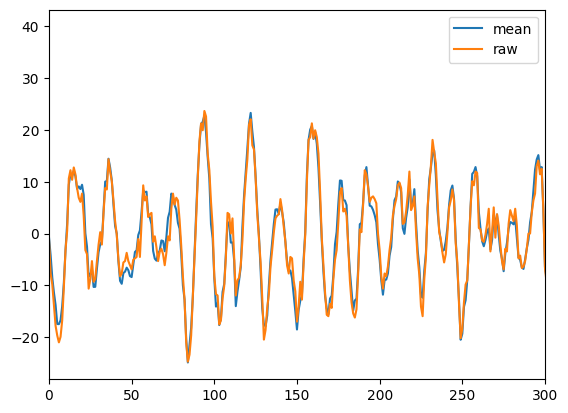

In [102]:
m = s.mean(axis=0)
r = np.diff(raw_data[0,:2000])*-1
plt.plot(m, label='mean')
plt.plot(r, label='raw')
plt.xlim(0,300)
plt.legend()

  0%|          | 0/118 [00:00<?, ?it/s]

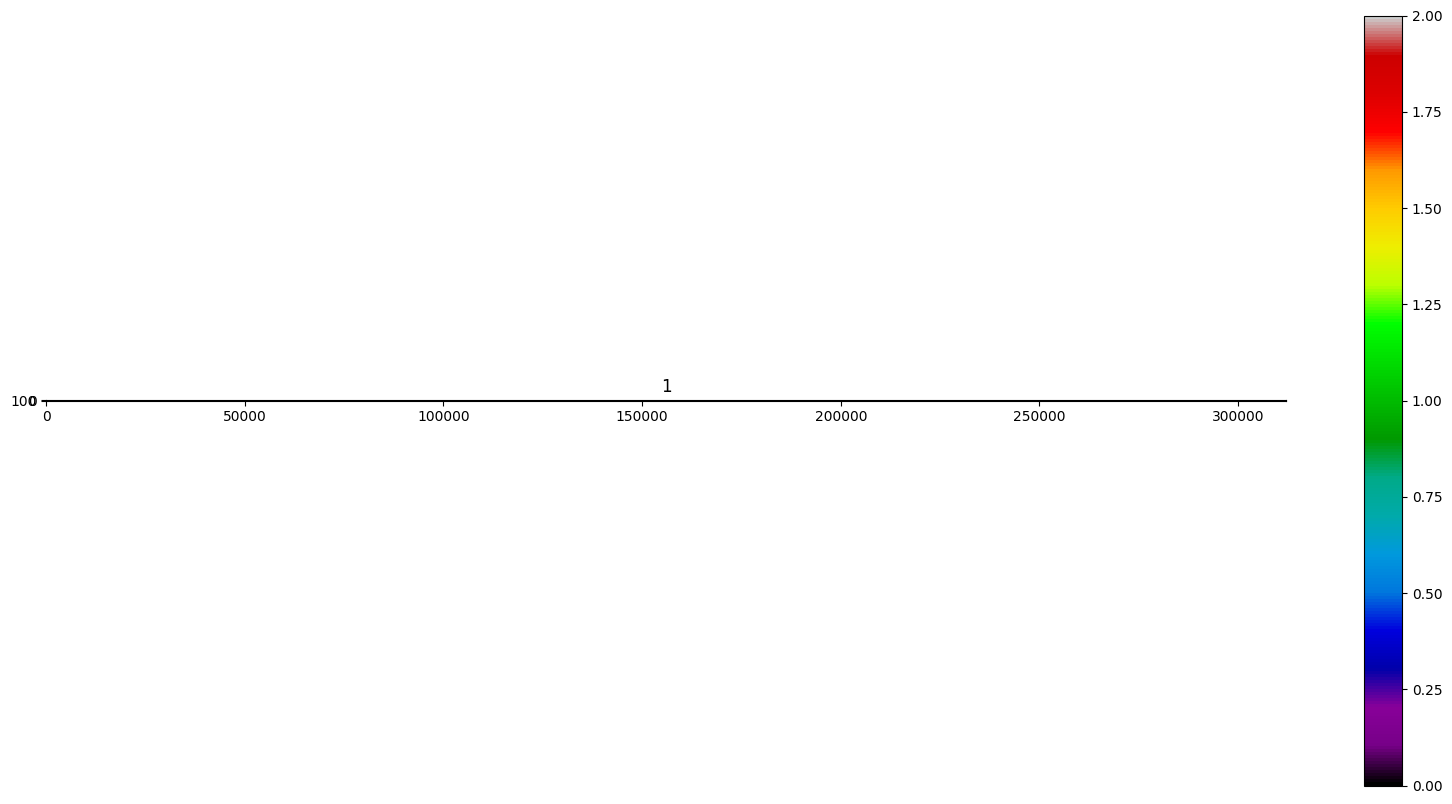

In [ ]:

# diff = np.diff(data,axis=2)
diff = d.copy()

diff = diff[:,:2048//4]

max_v = np.nanmax(diff)
min_v = np.nanmin(diff)

# normalize 0-2
# diff = (diff - min_v) / (max_v - min_v)


row_flattened = diff.reshape(-1, diff.shape[-1])


n = diff.shape[0]

col_mask = np.repeat(soz, n).reshape(-1, 1)
row_mask = np.tile(soz, n).reshape(-1, 1)
name = np.tile(name_mask, n).reshape(-1, 1)


q = 5
row = np.tile(row_mask, q)
col = np.tile(col_mask, q)
name = np.tile(name, q)

mask = np.concatenate([row, col], axis=1)

# Convert mask to float type to handle the max_v and min_v values
mask = mask.astype(float)

# # fill mask with max where 1 and min where 0
# mask[mask == 1] = 1
# mask[mask == 0] = 0

mask = np.concatenate([mask, name], axis=1)

out = np.concatenate([mask, row_flattened], axis=1)

# drange = np.nanmax(np.abs(max_v), np.abs(min_v))

z = 1
for i in tqdm(np.arange(0,col.shape[0],n)):
    plt.figure(figsize=(20,10))
    plt.imshow(out[i:(i+n), :], cmap='nipy_spectral', vmin=0, vmax=2)
    plt.title(f'{z}')
    plt.colorbar()
    # plt.savefig(f'test_{z:03}.png')
    # plt.close()
    z += 1
    break
    
    